# GDAL VRT approach

This is a notebook demonstrates working with Sentinel-1 RTC imagery that has been processsed on the ASF On-Demand server and downloaded locally. 

The access point for data in this notebook is a directory containing un-zipped directories of RTC scenes.

The previous notebook demonstrated an approach using the xarray function `open_mfdataset()`. Because of the size and some  characteristics of the dataset, this approach can be computationally expensive. Another way to approach reading in large amounts of data to avoid these issues is to use the gdal `build_vrt` command. VRT is short for GDAL Virtual Format. VRT objects create an xml file from a list of geotiff files. The xml contains a mapping of all of the specified raster files so that we essentially have the spatial information that would have been used to create the full data object, and all of the information we need for a clip. VRT objects are able to handle the mismatch of grids within the stack of files, so does not encounter the memory issues that we get when trying the `xr.open_mfdataset()` approach with dask. 


You will see that this approach let's you read in the data stack with less computational expense, but because of how the data is represented, some metadata is lost and must be re-structured. We will go through those steps here, with explanations of the xarray tools we use along the way. 

## Learning goals

**Techniques (xarray, python and general):** <br>
- Build gdal VRT objects
- Read in data using `rioxarray.open_rasterio()`
- Clip raster object by a vector using `rioxarray.clip()`
- Indexing and selecting xarray objects by dimensional and non-dimensional coordinates
- Formatting time-aware xarray objects

**High-level science goals:** <br>
- Organize large set of geotiff files stored locally
- Use VRT objects to create xarray objects from large data stacks
- Extract and organize metadata stored in filenames and text files
- Handle nodata values 

## Software and setup

In [1]:
import os
import xarray as xr
import rioxarray as rio
import geopandas as gpd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask
import holoviews as hv
from holoviews import opts
import markdown
import pathlib
from s1_tools import points2coords
from pathlib import Path

**instead of re-writing every function that's used again, going to read them in from s1_tools package after they've been defined in a notebook - so next cell should be deleted**

In [2]:
# read in PC data (We will use this later for a comparison)
#we'll use this function to get bounding box coordinates from a list of points 
def points2coords(pt_ls): #should be [xmin, ymin, xmax, ymax]
    
    coords_ls = [(pt_ls[0], pt_ls[1]), (pt_ls[0], pt_ls[3]),
                 (pt_ls[2], pt_ls[3]), (pt_ls[2], pt_ls[1]),
                 (pt_ls[0], pt_ls[1])]
    return coords_ls
    



Set up some string variables for directory paths. We need to pass `xr.open_mfdataset()` a list of all files to read in. Currently, the file structure is organized so that each scene has its own sub-directory within `unzipped_keep`. Within each sub-directory are several files - we want to extract the tif files containing RTC imagery for the VV and VH polarizations for each scene. The function `extract_tif_fnames()` takes a path to the directory containing the sub-directories for all scenes and returns a list of the filenames for VV-polarization tif files and a separate list of filenames for VH-polarization tif files. This is the same as what we used in the previous notebook but with an additional list of names of README files for each Sentinel-1 scene. This will be used to extract important metadata later on.

In [3]:
dir_path_all = '/home/emmamarshall/Desktop/siparcs/asf_rtc_data/unzipped_keep/'
scenes_ls = os.listdir(dir_path_all)

def extract_tif_fnames(scene_path):
    ''' return a list of files associated with a single S1 scene'''
    scene_files_ls = os.listdir(dir_path_all + scene_path)
        
    #make object for readme file
    a = [file for file in scene_files_ls if file.endswith('README.md.txt')]
    
    scene_files_vv = [fname for fname in scene_files_ls if fname.endswith('_VH.tif')]
    scene_files_vh = [fname for fname in scene_files_ls if fname.endswith('_VV.tif')]
    scene_files_ls = [fname for fname in scene_files_ls if fname.endswith('_ls_map.tif')]
    #scene_files_rm = [file for file in scene_files_ls if file.endswith('README.md.txt')]
    
    return scene_files_vv, scene_files_vh, scene_files_ls, a

Every scene will have the following four elements:

In [4]:
extract_tif_fnames(scenes_ls[0])

(['S1A_IW_20210821T000314_DVP_RTC30_G_gpuned_748F_VH.tif'],
 ['S1A_IW_20210821T000314_DVP_RTC30_G_gpuned_748F_VV.tif'],
 ['S1A_IW_20210821T000314_DVP_RTC30_G_gpuned_748F_ls_map.tif'],
 ['S1A_IW_20210821T000314_DVP_RTC30_G_gpuned_748F.README.md.txt'])

Now we need to attach the filenames to the full path to each file. We will end up with a list of full paths to VV and VH band imagery, layover shadow map and README files.

In [5]:
fpaths_vv, fpaths_vh, fpaths_ls, fpaths_rm = [],[],[], []

for element in range(len(scenes_ls)):
    
    good_files = extract_tif_fnames(scenes_ls[element])
    
    path_vh = dir_path_all + scenes_ls[element] + '/' + good_files[0][0]
    path_vv = dir_path_all + scenes_ls[element] + '/' + good_files[1][0]
    path_ls = dir_path_all + scenes_ls[element] + '/' + good_files[2][0]
    path_readme = dir_path_all + scenes_ls[element] + '/' + good_files[3][0]
    
    fpaths_vv.append(path_vv)
    fpaths_vh.append(path_vh)
    fpaths_ls.append(path_ls)
    fpaths_rm.append(path_readme)

## Extract SLC granule ID from readme



The original granule ID associated with the Sentinel-1 data product published by the European Space Agency contains metadata that it would be helpful for us to attach to our xarray objects. The README file that is associated with every scene contains the source granule used to generate that product. 

The following two functions will be used to extract the source granule ID from each README file then to attatch the ID as a coordinate to the xarray object containing the SAR imagery.

In [6]:
def extract_granule_id(filepath):
    ''' this function takes a filepath to the readme associated with an S1 scene and returns the source granule id used to generate the RTC imagery''' 

    md = markdown.Markdown(extensions=['meta'])
    data = pathlib.Path(filepath).read_text()
    #this text predates granule ID in readme
    gran_str = 'The source granule used to generate the products contained in this folder is:\n'
    split = data.split(gran_str)
    #isolate the granule id
    post = split[1][:67]
    
    return post

In [7]:
def make_granule_coord(readme_fpaths_ls):
    '''this fn takes a list of the filepaths to every read me, extracts the granule ID, 
    extracts acq date for each granule ID, organizes this as an array that
    can be assigned as a coord to an xr object'''
    
    granule_ls = [extract_granule_id(readme_fpaths_ls[element]) for element in range(len(readme_fpaths_ls))]
    
    acq_date = [pd.to_datetime(granule[17:25]) for granule in granule_ls]

    granule_da = xr.DataArray(data = granule_ls, 
                              dims = ['acq_date'],
                              coords = {'acq_date':acq_date},
                             attrs = {'description': 'source granule ID for ASF-processed S1 RTC imagery, extracted from README files for each scene'},
                             name = 'granule_id')
    #granule_da = granule_da.sortby(acq_date)
    granule_da = granule_da.sortby(granule_da.acq_date)
   # granule_tuple = tuple(zip(acq_date, granule_ls))
    
    return granule_da

The object below (`granule_da`) is a 2-dimensional `xr.DataArray` that contains an acquisition date coordinate dimension and an array of Sentinel-1 granule IDs. It will be used later when we are merging metadata with our imagery object.

In [8]:
granule_da = make_granule_coord(fpaths_rm)

In [9]:
g = str(granule_da.sel(acq_date='2021-06-02').values)
print(g)
print(g[56:62])


S1A_IW_SLC__1SDV_20210602T120543_20210602T120610_038161_0480FD_893F
0480FD


The top line above is the full granule ID for the Sentinel-1 acquisition from 6/2/2021. You can read about the Sentinel-1 file naming convention [here](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-1-sar/naming-conventions), but for now we are interested in the 6-digit mission data take ID (`0480FD` in the above cell)

### Read in vector data 
*probably move this elsewehre in nb* 

We will use this vector data object later but we will read it in as a `geopandas.GeoDataFrame` object now. It is called PC aoi because the GeoJSON file was created off of the spatial extent of the SAR dat we will access from Microsoft Planetary Computer, in order to have comparable datasets.

In [10]:
pc_aoi = gpd.read_file('https://github.com/e-marshall/sentinel1_rtc/raw/main/hma_rtc_aoi.geojson')

pc_aoi

,geometry
0,"POLYGON ((619420.000 3089790.000, 628100.000 3..."


<AxesSubplot:>

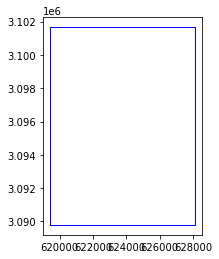

In [11]:
pc_aoi.plot(edgecolor='blue', facecolor='None')

## Create VRT objects

We will be using the `gdalbuildvrt` command. You can find out more about it [here](https://manpages.ubuntu.com/manpages/bionic/man1/gdalbuildvrt.1.html). This command can make a VRT that either tiles the listed files into a large mosaic, or places them each in a separate band of the VRT. Because we are dealing with a temporal stack of images we want to use the `-separate` flag to place each file into a band of the VRT. </br>
Because we are making a VRT from a large number of files, we'll supply a text file with the full path for each file rather than include these at the end of the command line. We'll use the same lists of filepaths that we used in the `xr.open_mfdataset()` approach but this time we will write them to text files that we pass to the `gdalbuildvrt` command.

In [12]:
with open('/home/emmamarshall/Desktop/data/written_data/s1_vv_fpaths.txt','w') as fp:
    for item in fpaths_vv:
        #write each item on a new line
        fp.write('%s\n' % item)

with open('/home/emmamarshall/Desktop/data/written_data/s1_vh_fpaths.txt','w') as fp:
    for item in fpaths_vh:
        fp.write('%s\n' % item)

with open('/home/emmamarshall/Desktop/data/written_data/s1_ls_fpaths.txt','w') as fp:
    for item in fpaths_ls:
        fp.write('%s\n' % item)

**fix the next cell use cell magic**

Next, we will use gdal command line tools to create the VRT objects:

In [13]:
#`gdalbuildvrt -separate -input_file_list /path/to/my_list.txt vrt_fname.vrt` </br>

#% gdalbuildvrt -separate -input_file_list /home/emmamarshall/Desktop/data/written_data/s1_vv_fpaths.txt s1_stackVV.vrt
#% gdalbuildvrt -separate -input_file_list /home/emmamarshall/Desktop/data/written_data/s1_vh_fpaths.txt s1_stackVH.vrt
#% gdalbuildvrt -separate -input_file_list /home/emmamarshall/Desktop/data/written_data/s1_ls_fpaths.txt s1_stackLS.vrt



Read in the VRT files using the `rioxarray` function `open_rasterio()`:

In [14]:
vrt_vv = rio.open_rasterio('/home/emmamarshall/Desktop/siparcs/s1_stackVV.vrt', chunks='auto').squeeze()
vrt_vh = rio.open_rasterio('/home/emmamarshall/Desktop/siparcs/s1_stackVH.vrt', chunks='auto').squeeze()
vrt_ls = rio.open_rasterio('/home/emmamarshall/Desktop/siparcs/s1_stackLS.vrt', chunks='auto').squeeze()

Building the `VRT` object assigns every object in the .txt file to a different band. In doing this, we lost the metadata that is associated with the files. We use a function that is similar (in some ways) to the `preprocess` call above, to extract metadata from the file name and attach it to the xarray objects that we read in from VRTs.

## Extract metadata

The following function is very similar to the `preprocess()` function used in the previous notebook. It extracts metadata contained in the filename and organizes it as a dictionary that can be attached to an xarray object.

In [15]:
def extract_metadata_attrs(inputfname):
    
    #vv_fn = da_orig.encoding['source'][113:]
    vv_fn = inputfname[113:]
    
    sensor = vv_fn[0:3]
    beam_mode = vv_fn[4:6]
    acq_date_raw = vv_fn[7:15] #need to parse further
    acq_date = pd.to_datetime(acq_date_raw, format='%Y%m%d')
    #print(acq_date)
    acq_time = vv_fn[15:22]
    pol_type = vv_fn[23:25] # dual pol ...
   # primary_pol = vv_fn[25:26] # VV ...
    orbit_type = vv_fn[25:26]
   # orbit_type = vv_fn[26:27] #Precise (P), Restituted (R), or Original Predicted (O)
    terrain_correction_pixel_spacing = vv_fn[27:32] #Terrain Correction Pixel Spacing
    rtc_alg = vv_fn[33:34] #Software Package Used: GAMMA (G)
    output = vv_fn[35] #  Gamma-0 (g) or Sigma-0 (s) Output
    output_type = vv_fn[36] #Power (p) or Decibel (d) or Amplitude (a) Output
    masked = vv_fn[37]  #Unmasked (u) or Water Masked (w)
    filtered = vv_fn[38]  # Not Filtered (n) or Filtered (f)
    area =  vv_fn[39]       # Entire Area (e) or Clipped Area (c)
    tbd =   vv_fn[40]   #Dead Reckoning (d) or DEM Matching (m)
   # product_id  = vv_fn[56:62]  #Product ID
    product_id = vv_fn[42:46]

    attrs_dict = { 'sensor': sensor,
                        'beam_mode':beam_mode, 
                        'acquisition_date' : acq_date,
                        'acquisition_time': acq_time,
                        'polarisation_type': pol_type,
                     #  'primary_polarisation': primary_pol,
                        'orbit_type': orbit_type,
                        'terrain_correction_pixel_spacing' : terrain_correction_pixel_spacing,
                        'output_format': output,
                        'output_type': output_type,
                        'masked' : masked,
                        'filtered':filtered,
                        'area':area,
                        'product_id': product_id 
                 }
    return attrs_dict

The acquisition dates extracted from the VV, VH and Ls geotiff files should be identical, but we read in all three here just to confirm:

In [16]:
acq_dates_vh = [extract_metadata_attrs(fpaths_vh[file])['acquisition_date'].strftime('%m/%d/%Y') for file in range(len(fpaths_vh))]
acq_dates_vv = [extract_metadata_attrs(fpaths_vv[file])['acquisition_date'].strftime('%m/%d/%Y') for file in range(len(fpaths_vv))]
acq_dates_ls = [extract_metadata_attrs(fpaths_ls[file])['acquisition_date'].strftime('%m/%d/%Y') for file in range(len(fpaths_vv))]

Do the same for acquisition time:

In [17]:
import time
acq_times_vh = [time.strptime(extract_metadata_attrs(fpaths_vh[file])['acquisition_time'],'T%H%M%S') for file in range(len(fpaths_vh))]
acq_times_vv = [time.strptime(extract_metadata_attrs(fpaths_vv[file])['acquisition_time'],'T%H%M%S') for file in range(len(fpaths_vv))]
acq_times_ls = [time.strptime(extract_metadata_attrs(fpaths_ls[file])['acquisition_time'],'T%H%M%S') for file in range(len(fpaths_ls))]

#acq_times_vv = [extract_metadata_attrs(fpaths_vv[file])['acquisition_time'].strftime('%hh%mm%ss') for file in range(len(fpaths_vv))]
#acq_times_ls = [extract_metadata_attrs(fpaths_ls[file])['acquisition_time'].strftime('%hh%mm%ss') for file in range(len(fpaths_vv))]

The acquisition dates for VV, VH and LS **should be** the same. As a check, you can confirm this by creating both objects and comparing them.`

In [18]:
acq_dates_vh == acq_dates_vv == acq_dates_ls

True

In [19]:
acq_times_vh == acq_times_vv == acq_times_ls

True

We can now assign the list of acquisition dates as coordinates to the xarray objects. Use `pd.to_datetime()` to do this as time-aware coordinate values.

In [20]:
vrt_vv = vrt_vv.assign_coords({'band':pd.to_datetime(acq_dates_vv, format='%m/%d/%Y')})
vrt_vh = vrt_vh.assign_coords({'band':pd.to_datetime(acq_dates_vh, format='%m/%d/%Y')})
vrt_ls = vrt_ls.assign_coords({'band':pd.to_datetime(acq_dates_ls, format='%m/%d/%Y')})

Merge the three `xr.DataArrays` together into an `xr.Dataset`.

In [21]:
vrt_merge = xr.Dataset({'vv':vrt_vv, 
                      'vh':vrt_vh,
                       'ls':vrt_ls}).rename_dims({'band':'acq_date'}).rename({'band':'acq_date'})

In [22]:
vrt_merge

<xarray.Dataset>
Dimensions:      (acq_date: 103, x: 17452, y: 13379)
Coordinates:
  * acq_date     (acq_date) datetime64[ns] 2021-08-21 2022-01-16 ... 2022-04-06
  * x            (x) float64 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y            (y) float64 3.309e+06 3.309e+06 ... 2.907e+06 2.907e+06
    spatial_ref  int64 0
Data variables:
    vv           (acq_date, y, x) float32 dask.array<chunksize=(1, 5760, 5760), meta=np.ndarray>
    vh           (acq_date, y, x) float32 dask.array<chunksize=(1, 5760, 5760), meta=np.ndarray>
    ls           (acq_date, y, x) uint8 dask.array<chunksize=(1, 11520, 11520), meta=np.ndarray>

The files are not organized by time in the directory, so the files are not read in in temporal order when we create the VRT and `xr.Dataset` objects. Once we have attached the temporal metadata to the xarray objects composed from VRT, we can use `.sortby()` to organize the dataset along time time dimension:

In [23]:
vrt_merge = vrt_merge.sortby(vrt_merge.acq_date)
vrt_merge

<xarray.Dataset>
Dimensions:      (acq_date: 103, x: 17452, y: 13379)
Coordinates:
  * acq_date     (acq_date) datetime64[ns] 2021-05-02 2021-05-05 ... 2022-05-21
  * x            (x) float64 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y            (y) float64 3.309e+06 3.309e+06 ... 2.907e+06 2.907e+06
    spatial_ref  int64 0
Data variables:
    vv           (acq_date, y, x) float32 dask.array<chunksize=(1, 5760, 5760), meta=np.ndarray>
    vh           (acq_date, y, x) float32 dask.array<chunksize=(1, 5760, 5760), meta=np.ndarray>
    ls           (acq_date, y, x) uint8 dask.array<chunksize=(1, 11520, 11520), meta=np.ndarray>

You can see that the chunking here is much more reasonable, with 1236 total chunks compared to 103 or 317,240 chunks from the `open_mfdataset()` approach.

### Clip by vector data

Clip the full object by the same AOI as above. Just as in the last notebook, we will use the [`rioxarray.clip()` method](https://corteva.github.io/rioxarray/stable/examples/clip_geom.html).

In [24]:
vrt_clip = vrt_merge.rio.clip(pc_aoi.geometry, pc_aoi.crs)
vrt_clip

<xarray.Dataset>
Dimensions:      (acq_date: 103, x: 290, y: 396)
Coordinates:
  * acq_date     (acq_date) datetime64[ns] 2021-05-02 2021-05-05 ... 2022-05-21
  * x            (x) float64 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y            (y) float64 3.102e+06 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    spatial_ref  int64 0
Data variables:
    vv           (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh           (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls           (acq_date, y, x) uint8 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

## Merge metadata

We had important metadata stored in the individual filenames of each Sentinel-1 scene that was dropped when we converted them to VRT objects. Let's use the original filenames to extract the metadata and assign the data as coordinates of our formatted xarray object:

In [25]:
meta_attrs_ls_vv = [extract_metadata_attrs(fpaths_vv[file]) for file in range(len(fpaths_vv))]

In [26]:
meta_dict_927 = dict(zip(acq_dates_vv, meta_attrs_ls_vv))

In [27]:
def stacked_meta_tuple(input_ls):
    '''breaking up the earlier function into 2...
    this function takes a list of dictionaries where each dict is metadata for a given time step,
    returns a tuple. input list is re-organized to a tuple where each [0] values is a metadata category (ie. sensor) and 
    [1] is a time series of the categories values over time (ie. S1A, S1A, S1A ...)'''
    
    meta_dict = input_ls[0]
    ticker = 0
    attrs_dicts, keys_ls = [],[]
    
    for key in meta_dict:
        if key == 'acquisition_date': 
            pass
        else:
            
            key_dict = {f'{key}':[input_ls[ticker][key] for ticker in range(len(input_ls))]}
            ticker+=1
            attrs_dicts.append(key_dict)
            keys_ls.append(key)
    
    full_tuple = tuple(zip(keys_ls, attrs_dicts))
    
    return full_tuple

In [28]:
def apply_meta_coords(input_xr, input_tuple):
    
    out_xr = xr.Dataset(
        input_xr.data_vars,
        coords = {'x': input_xr.x.data,
                  'y': input_xr.y.data,
                  'acq_date': input_xr.acq_date.data,
                 }
    )
    # now apply metadata coords 
    for element in range(len(input_tuple)):
        key = input_tuple[element][0]
        coord = list(input_tuple[element][1].values())[0]
        out_xr.coords[f'{key}'] = ('acq_date', coord)
       # print(key)
       # print(out_xr.coords.values)
        
    return out_xr

In [29]:
meta_tuple = stacked_meta_tuple(meta_attrs_ls_vv)


In [30]:
vrt_full = apply_meta_coords(vrt_clip, meta_tuple)

In [31]:
vrt_full

<xarray.Dataset>
Dimensions:                           (acq_date: 103, x: 290, y: 396)
Coordinates: (12/16)
  * acq_date                          (acq_date) datetime64[ns] 2021-05-02 .....
  * x                                 (x) float64 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3.102e+06 ... 3.09e+06
    spatial_ref                       int64 0
    sensor                            (acq_date) <U3 'S1A' 'S1A' ... 'S1A' 'S1A'
    beam_mode                         (acq_date) <U2 'IW' 'IW' ... 'IW' 'IW'
    ...                                ...
    output_format                     (acq_date) <U1 'g' 'g' 'g' ... 'g' 'g' 'g'
    output_type                       (acq_date) <U1 'p' 'p' 'p' ... 'p' 'p' 'p'
    masked                            (acq_date) <U1 'u' 'u' 'u' ... 'u' 'u' 'u'
    filtered                          (acq_date) <U1 'n' 'n' 'n' ... 'n' 'n' 'n'
    area                              (acq_date) <U1 'e' 'e' 'e' ... 'e' 'e' 'e'
    product_id                        (acq_date) <U4 '748F' '0D1E' ... 'BD36'
Data variables:
    vv                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls                                (acq_date, y, x) uint8 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

### Add granule ID as another non-dimensional coordinate

Using the `granule_da` object created earlier

In [32]:
granule_da

<xarray.DataArray 'granule_id' (acq_date: 103)>
array(['S1A_IW_SLC__1SDV_20210502T121414_20210502T121441_037709_047321_900F',
       'S1A_IW_SLC__1SDV_20210505T000307_20210505T000334_037745_047463_4DEF',
       'S1A_IW_SLC__1SDV_20210509T120542_20210509T120609_037811_047676_9EBD',
       'S1A_IW_SLC__1SDV_20210514T121349_20210514T121416_037884_047898_4702',
       'S1A_IW_SLC__1SDV_20210514T121414_20210514T121442_037884_047898_FE6F',
       'S1A_IW_SLC__1SDV_20210517T000308_20210517T000335_037920_0479A9_2A18',
       'S1A_IW_SLC__1SDV_20210521T120543_20210521T120609_037986_047BBD_1CA0',
       'S1A_IW_SLC__1SDV_20210526T121350_20210526T121417_038059_047DE5_0E67',
       'S1A_IW_SLC__1SDV_20210529T000309_20210529T000336_038095_047EF4_5449',
       'S1A_IW_SLC__1SDV_20210602T120543_20210602T120610_038161_0480FD_893F',
       'S1A_IW_SLC__1SDV_20210607T121351_20210607T121418_038234_048318_9B64',
       'S1A_IW_SLC__1SDV_20210610T000310_20210610T000337_038270_04841E_601A',
       'S1A_IW_SLC__1SDV_20210614T120544_20210614T120611_038336_04862F_337B',
       'S1A_IW_SLC__1SDV_20210619T121352_20210619T121419_038409_04884C_1DBA',
       'S1A_IW_SLC__1SDV_20210622T000310_20210622T000337_038445_04895A_842E',
       'S1A_IW_SLC__1SDV_20210626T120545_20210626T120612_038511_048B6C_9585',
       'S1A_IW_SLC__1SDV_20210701T121352_20210701T121419_038584_048D87_F95C',
       'S1A_IW_SLC__1SDV_20210701T121417_20210701T121445_038584_048D87_C79E',
       'S1A_IW_SLC__1SDV_20210704T000311_20210704T000338_038620_048E99_1BAA',
       'S1A_IW_SLC__1SDV_20210708T120545_20210708T120612_038686_0490AD_DD9E',
...
       'S1A_IW_SLC__1SDV_20220317T120545_20220317T120612_042361_050CE5_4CCF',
       'S1A_IW_SLC__1SDV_20220322T121353_20220322T121420_042434_050F59_A1B6',
       'S1A_IW_SLC__1SDV_20220325T000312_20220325T000339_042470_051096_BA6F',
       'S1A_IW_SLC__1SDV_20220329T120546_20220329T120613_042536_0512D7_425A',
       'S1A_IW_SLC__1SDV_20220403T121418_20220403T121446_042609_05154A_51E7',
       'S1A_IW_SLC__1SDV_20220403T121353_20220403T121420_042609_05154A_3FE7',
       'S1A_IW_SLC__1SDV_20220406T000312_20220406T000339_042645_051682_4B40',
       'S1A_IW_SLC__1SDV_20220410T120546_20220410T120613_042711_0518C0_3349',
       'S1A_IW_SLC__1SDV_20220415T121353_20220415T121420_042784_051B30_EB87',
       'S1A_IW_SLC__1SDV_20220418T000312_20220418T000339_042820_051C63_CAB2',
       'S1A_IW_SLC__1SDV_20220422T120547_20220422T120614_042886_051E96_41EE',
       'S1A_IW_SLC__1SDV_20220427T121354_20220427T121421_042959_0520EE_A42D',
       'S1A_IW_SLC__1SDV_20220430T000313_20220430T000340_042995_05221E_46A1',
       'S1A_IW_SLC__1SDV_20220504T120547_20220504T120614_043061_05245F_6F62',
       'S1A_IW_SLC__1SDV_20220509T121355_20220509T121422_043134_0526C4_092E',
       'S1A_IW_SLC__1SDV_20220516T120548_20220516T120615_043236_0529DD_42D2',
       'S1A_IW_SLC__1SDV_20220521T121420_20220521T121448_043309_052C00_493D',
       'S1A_IW_SLC__1SDV_20220521T121420_20220521T121448_043309_052C00_493D',
       'S1A_IW_SLC__1SDV_20220521T121356_20220521T121423_043309_052C00_FE88'],
      dtype='<U67')
Coordinates:
  * acq_date  (acq_date) datetime64[ns] 2021-05-02 2021-05-05 ... 2022-05-21
Attributes:
    description:  source granule ID for ASF-processed S1 RTC imagery, extract...

In [33]:
vrt_full = xr.combine_by_coords([vrt_full, granule_da])
vrt_full = vrt_full.assign_coords({'granule_id':vrt_full.granule_id})

In [34]:
vrt_full

<xarray.Dataset>
Dimensions:                           (acq_date: 103, x: 290, y: 396)
Coordinates: (12/17)
  * acq_date                          (acq_date) datetime64[ns] 2021-05-02 .....
    granule_id                        (acq_date) <U67 'S1A_IW_SLC__1SDV_20210...
  * x                                 (x) float64 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3.102e+06 ... 3.09e+06
    spatial_ref                       int64 0
    sensor                            (acq_date) <U3 'S1A' 'S1A' ... 'S1A' 'S1A'
    ...                                ...
    output_format                     (acq_date) <U1 'g' 'g' 'g' ... 'g' 'g' 'g'
    output_type                       (acq_date) <U1 'p' 'p' 'p' ... 'p' 'p' 'p'
    masked                            (acq_date) <U1 'u' 'u' 'u' ... 'u' 'u' 'u'
    filtered                          (acq_date) <U1 'n' 'n' 'n' ... 'n' 'n' 'n'
    area                              (acq_date) <U1 'e' 'e' 'e' ... 'e' 'e' 'e'
    product_id                        (acq_date) <U4 '748F' '0D1E' ... 'BD36'
Data variables:
    vv                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls                                (acq_date, y, x) uint8 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

## Format acquisition time

Acquisition time comes as a string with form `THHMMSS`. We would like the `acquisition_time` coordinate to be time aware. To do this, we'll use the `np.vectorize()` [function](https://numpy.org/doc/stable/reference/generated/numpy.vectorize.html) to apply the string to datetime64 conversion to every element of the `acq_time` coordinate array. (better way to do this?)

In [35]:
def str_to_time(input_str):
    #print(input_str)
    hour = input_str[1:3]
    minute = input_str[3:5]
    sec = input_str[5:7]
    time = hour + ':' + minute + ':' + sec
    
    time_td = pd.to_datetime(time).to_datetime64()
    return time_td


In [36]:
def format_acq_time_coord(input_xr):
    
    time_str = np.vectorize(str_to_time)
    
    acq_times_format = time_str(input_xr['acquisition_time'].data)
    #input_xr.coords['AA_acq_time'] = ('acq_date', time_str(input_xr['acquisition_time'].data))
    
    input_xr.coords['acquisition_time'] = ('acq_date', acq_times_format)
    
    return input_xr

In [37]:
vrt_full = format_acq_time_coord(vrt_full)

In [38]:
vrt_full

<xarray.Dataset>
Dimensions:                           (acq_date: 103, x: 290, y: 396)
Coordinates: (12/17)
  * acq_date                          (acq_date) datetime64[ns] 2021-05-02 .....
    granule_id                        (acq_date) <U67 'S1A_IW_SLC__1SDV_20210...
  * x                                 (x) float64 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3.102e+06 ... 3.09e+06
    spatial_ref                       int64 0
    sensor                            (acq_date) <U3 'S1A' 'S1A' ... 'S1A' 'S1A'
    ...                                ...
    output_format                     (acq_date) <U1 'g' 'g' 'g' ... 'g' 'g' 'g'
    output_type                       (acq_date) <U1 'p' 'p' 'p' ... 'p' 'p' 'p'
    masked                            (acq_date) <U1 'u' 'u' 'u' ... 'u' 'u' 'u'
    filtered                          (acq_date) <U1 'n' 'n' 'n' ... 'n' 'n' 'n'
    area                              (acq_date) <U1 'e' 'e' 'e' ... 'e' 'e' 'e'
    product_id                        (acq_date) <U4 '748F' '0D1E' ... 'BD36'
Data variables:
    vv                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls                                (acq_date, y, x) uint8 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

You can see that all of the acquisition times are roughly either around 00:00 or 12:00 (check that these are UTC? what local time? 6 am / 6pm ish?). We can use the different times of the acquistitions to group the data by orbital direction ie. categorize acquisitions as ascending or descending passes

## Add orbital direction coord

1. assign coord thats acq_time.dt.hour
2. use np where to translate hour to asc or desc
3. assign coord for orbital pass
4. drop dims for acq time, hour

setting dtype = datetime64 f up the date??


In [39]:
vrt_full.acquisition_time.dt.hour

<xarray.DataArray 'hour' (acq_date: 103)>
array([ 0, 12, 12, 12, 12, 12, 12,  0,  0, 12, 12,  0, 12,  0, 12,  0, 12,
       12,  0, 12, 12, 12,  0,  0, 12, 12, 12,  0,  0, 12,  0, 12, 12, 12,
       12, 12,  0,  0, 12,  0, 12, 12, 12, 12, 12, 12, 12,  0, 12, 12, 12,
       12,  0, 12,  0, 12, 12, 12, 12, 12, 12,  0, 12, 12,  0, 12, 12, 12,
       12, 12,  0, 12, 12,  0,  0, 12, 12, 12, 12, 12, 12,  0, 12, 12,  0,
        0,  0, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  0,  0,  0, 12, 12,
        0])
Coordinates: (12/15)
  * acq_date                          (acq_date) datetime64[ns] 2021-05-02 .....
    granule_id                        (acq_date) <U67 'S1A_IW_SLC__1SDV_20210...
    spatial_ref                       int64 0
    sensor                            (acq_date) <U3 'S1A' 'S1A' ... 'S1A' 'S1A'
    beam_mode                         (acq_date) <U2 'IW' 'IW' ... 'IW' 'IW'
    acquisition_time                  (acq_date) datetime64[ns] 2022-09-27T00...
    ...                                ...
    output_format                     (acq_date) <U1 'g' 'g' 'g' ... 'g' 'g' 'g'
    output_type                       (acq_date) <U1 'p' 'p' 'p' ... 'p' 'p' 'p'
    masked                            (acq_date) <U1 'u' 'u' 'u' ... 'u' 'u' 'u'
    filtered                          (acq_date) <U1 'n' 'n' 'n' ... 'n' 'n' 'n'
    area                              (acq_date) <U1 'e' 'e' 'e' ... 'e' 'e' 'e'
    product_id                        (acq_date) <U4 '748F' '0D1E' ... 'BD36'

In [40]:
vrt_full.coords['acq_hour'] = ('acq_date', vrt_full.acquisition_time.dt.hour.values)

```{note}
better to have orbital dir as a dimension coord or non?
```


In [41]:
vrt_full.coords['orbital_dir'] = ('acq_date', xr.where(vrt_full.acq_hour.values == 0, 'asc', 'desc'))
#vrt_full = vrt_full.assign_coords({'orbital_pass': xr.where(vrt_full.acq_hour.values == 0, 'asc', 'desc')})

In [42]:
vrt_full

<xarray.Dataset>
Dimensions:                           (acq_date: 103, x: 290, y: 396)
Coordinates: (12/19)
  * acq_date                          (acq_date) datetime64[ns] 2021-05-02 .....
    granule_id                        (acq_date) <U67 'S1A_IW_SLC__1SDV_20210...
  * x                                 (x) float64 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3.102e+06 ... 3.09e+06
    spatial_ref                       int64 0
    sensor                            (acq_date) <U3 'S1A' 'S1A' ... 'S1A' 'S1A'
    ...                                ...
    masked                            (acq_date) <U1 'u' 'u' 'u' ... 'u' 'u' 'u'
    filtered                          (acq_date) <U1 'n' 'n' 'n' ... 'n' 'n' 'n'
    area                              (acq_date) <U1 'e' 'e' 'e' ... 'e' 'e' 'e'
    product_id                        (acq_date) <U4 '748F' '0D1E' ... 'BD36'
    acq_hour                          (acq_date) int64 0 12 12 12 ... 0 12 12 0
    orbital_dir                       (acq_date) <U4 'asc' 'desc' ... 'asc'
Data variables:
    vv                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls                                (acq_date, y, x) uint8 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

In [43]:
def add_orbital_dir_coord(input_xr):
    
    input_xr = input_xr.expand_dims('orbital_dir')
    input_xr = input_xr.assign_coords({'acq_hour':input_xr.acquisition_time.dt.hour})
    input_xr = input_xr.assign_coords(orbital_dir = xr.where(input_xr.acq_hour == 0, 'asc','desc'))
    #input_xr = input_xr.expand_dims('orbital_pass')
                                     #xr.where(input_xr.acq_hour == 0, 'asc', 'desc')})
   # input_xr = input_xr.assign_coords({'orbital_pass':xr.where(input_xr.acq_hour == 0, 'asc', 'desc')})
    #input_xr = input_xr.expand_dims({'pass':len(input_xr.orbital_pass)})

   # input_xr = input_xr.drop_dims(['acquisition_time'])
    #input_xr = input_xr.swap_dims({'orbital_pass':'orbital_dir'})
    
    return input_xr



In [44]:
#vrt_full = add_orbital_dir_coord(vrt_full)#

In [51]:
vrt_full

<xarray.Dataset>
Dimensions:                           (acq_date: 103, y: 396, x: 290)
Coordinates: (12/19)
  * acq_date                          (acq_date) datetime64[ns] 2021-05-02 .....
    granule_id                        (acq_date) <U67 'S1A_IW_SLC__1SDV_20210...
  * x                                 (x) float64 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3.102e+06 ... 3.09e+06
    spatial_ref                       int64 0
    sensor                            (acq_date) <U3 'S1A' 'S1A' ... 'S1A' 'S1A'
    ...                                ...
    masked                            (acq_date) <U1 'u' 'u' 'u' ... 'u' 'u' 'u'
    filtered                          (acq_date) <U1 'n' 'n' 'n' ... 'n' 'n' 'n'
    area                              (acq_date) <U1 'e' 'e' 'e' ... 'e' 'e' 'e'
    product_id                        (acq_date) <U4 '748F' '0D1E' ... 'BD36'
    acq_hour                          (acq_date) int64 0 12 12 12 ... 0 12 12 0
    orbital_dir                       (acq_date) <U4 'asc' 'desc' ... 'asc'
Data variables:
    vv                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls                                (acq_date, y, x) float64 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

## Handle nodata values

Another important difference between the `xr.open_mfdataset()` and VRT approaches is the handling of the nodata values. In the object built using `xr.open_mfdataset()`, nodata values are set to NaN while building the object from VRT files converts nodata values to zeros. This can cause a whole stream of problems later on so it is best to convert them to NaNs now. You can check the handling of nodata values in your dataset by using the `rio.nodata` accessor (shown below) which you can read about [here](https://corteva.github.io/rioxarray/stable/getting_started/nodata_management.html).

In [46]:
vrt_full.vv.isel(acq_date=0).rio.nodata

0.0

^ We want this to be a nan.

Using `rio.write_nodata()`:

In [47]:
vrt_new = vrt_full.rio.write_nodata(-9999, inplace=True)

AttributeError: 'RasterDataset' object has no attribute 'write_nodata'

```{note} 
note sure why that's not workiing rn
```

So using `xr.Dataset.where()` (don't think this will actually overwrite the official nodata value, but it should replace the zeros:

In [52]:
vrt_full =  vrt_full.where(vrt_full.vv != 0., np.nan, drop=False)


In [53]:
vrt_full

<xarray.Dataset>
Dimensions:                           (acq_date: 103, y: 396, x: 290)
Coordinates: (12/19)
  * acq_date                          (acq_date) datetime64[ns] 2021-05-02 .....
    granule_id                        (acq_date) <U67 'S1A_IW_SLC__1SDV_20210...
  * x                                 (x) float64 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3.102e+06 ... 3.09e+06
    spatial_ref                       int64 0
    sensor                            (acq_date) <U3 'S1A' 'S1A' ... 'S1A' 'S1A'
    ...                                ...
    masked                            (acq_date) <U1 'u' 'u' 'u' ... 'u' 'u' 'u'
    filtered                          (acq_date) <U1 'n' 'n' 'n' ... 'n' 'n' 'n'
    area                              (acq_date) <U1 'e' 'e' 'e' ... 'e' 'e' 'e'
    product_id                        (acq_date) <U4 '748F' '0D1E' ... 'BD36'
    acq_hour                          (acq_date) int64 0 12 12 12 ... 0 12 12 0
    orbital_dir                       (acq_date) <U4 'asc' 'desc' ... 'asc'
Data variables:
    vv                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls                                (acq_date, y, x) float64 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

Now we have all of the same metadata attached to our xarray datacube of Sentinel-1 RTC imagery that we had using the `xr.open_mfdataset()` approach, but we've done this with much less computational expense and a chunking strategy that is more appropriate for the nature of the dataset.

We'll store this object to use it in a later notebook.

In [54]:
%store vrt_full

Stored 'vrt_full' (Dataset)


## Quick visualization

Before we move on to the next notebook, let's take a quick look at the dataset. First, we will definte a function to convert the data from power scale to dB scale. This makes it easier to visualize variability in backscatter. Read more about SAR data scales [here](https://hyp3-docs.asf.alaska.edu/guides/rtc_product_guide/#sar-scales)

In [1]:
def power_to_db(input_arr):
    return (10*np.log10(np.abs(input_arr)))

Before moving on, let's visualize backscatter variability over time. To do this, we will perform a reduction along the `x` and `y` dimensions of the dataset. We can use built-in xarray plotting methods to plot the 2-dimensional data (backscatter and time, after reducing along `x` and `y`)

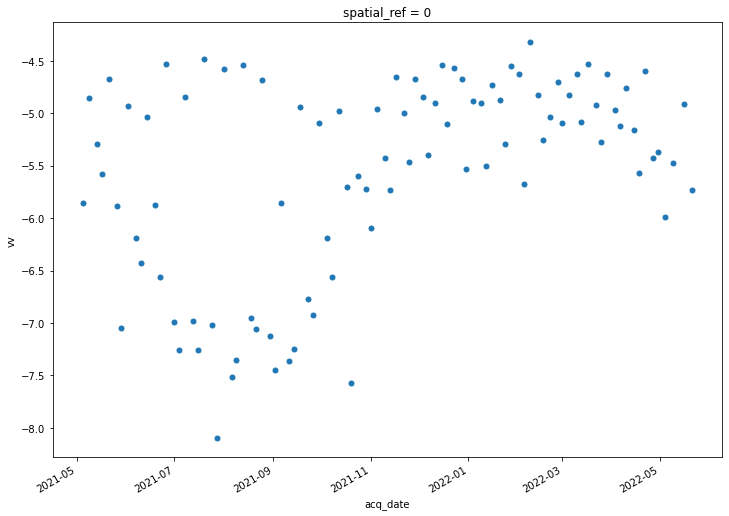

In [81]:
fig, ax = plt.subplots(figsize=(12,8))
power_to_db(vrt_full.vv.mean(dim=['x','y'])).plot(ax=ax, marker='o', linestyle='None', markersize=5);

Now what if we wanted to take a snap-shot look of backscatter at a single time step? We can still use xarray plotting methods, but this time will pass a 3-dimensional object (x,y and backscatter). We need to select a single element along the time dimension on which to call the plotting method: 

In [2]:
power_to_db(vrt_full.vv.isel(time=1)).plot(cmap=plt.cm.Greys_r);

NameError: name 'vrt_full' is not defined

The next notebook on [preliminary dataset inspection](asf_inspect.ipynb) demonstrates how to explore and familiarize oneself with the dataset now that we have it read in and organized.